## Create and test ion channel model

In [1]:
from experiments.ina_generic import (sakakibara_iv,
                                    sakakibara_act,
                                    sakakibara_inact,
                                    sakakibara_inact_kin_1,
                                    sakakibara_inact_kin_2,
                                    sakakibara_recov,
                                    sakakibara_recov_kin)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/Generic_iNa.mmt'

In [3]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_iv,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1,
                                                sakakibara_inact_kin_2,
                                                sakakibara_recov,
                                                sakakibara_recov_kin)

In [4]:
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [5]:

limits = {'ina.g_Na' : (0,100),
          'ina.Vhalf_m': (-60,40),
          'ina.k_m': (0,20),
          'ina.c_bm': (0.0001,1),
          'ina.c_am': (0.0001,10),
          'ina.sigma_m': (0,50),
          'ina.Vmax_m': (-60,40),
          'ina.Vhalf_h': (-100,0),
          'ina.k_h': (-20,0),
          'ina.c_bh': (0.0001,1),
          'ina.c_ah': (0,50),
          'ina.Vmax_h': (-100,0),
          'ina.sigma_h': (0,60),
          'ina.c_bj': (0,50),
          'ina.c_aj': (0,100),
          'ina.Vmax_j': (-100,0),
          'ina.sigma_j': (0,300)}



prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [6]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "generic_ina_testing.db"))

In [7]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [8]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 131072 particles


In [9]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000), # Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2072150657413763, '1': 1.2072150657413763, '2': 1.2072150657413763, '3': 1.2072150657413763, '4': 1.2072150657413763, '5': 1.2072150657413763, '6': 1.2072150657413763, '7': 1.2072150657413763, '8': 1.2072150657413763, '9': 1.2072150657413763, '10': 1.2072150657413763, '11': 1.2072150657413763, '12': 1.2072150657413763, '13': 1.2072150657413763, '14': 1.2072150657413763, '15': 1.2072150657413763, '16': 1.2072150657413763, '17': 1.2072150657413763, '18': 0.45569535711195136, '19': 0.3545292012046639, '20': 0.44065462334321276, '21': 1.2072150657413763, '22': 1.2072150657413763, '23': 1.2072150657413763, '24': 1.2072150657413763, '25': 1.2072150657413763, '26': 1.4267087140579902, '27': 1.4267087140579902, '28': 1.4267087140579902, '29': 1.4267087140579902, '30': 1.4267087140579902, '31': 0.5338596646548436, '32': 0.33176258901227934, '33': 0.3674613844474347, '34': 0.9167388223930231, '35': 1.4267087140579902, '36': 1.4267087140579902, '37': 0.19848

In [10]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [12]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-07-31 16:42:21.839637, end_time=None)>


In [13]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=20, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 6995
DEBUG:Epsilon:new eps, t=1, eps=16.715978838435518
INFO:ABC:t:1 eps:16.715978838435518
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 10219
DEBUG:Epsilon:new eps, t=2, eps=12.333606561686445
INFO:ABC:t:2 eps:12.333606561686445
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 14640
DEBUG:Epsilon:new eps, t=3, eps=9.387185109361495
INFO:ABC:t:3 eps:9.387185109361495
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 19657
DEBUG:Epsilon:new eps, t=4, eps=7.512283413672488
INFO:ABC:t:4 eps:7.512283413672488
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 24002
DEBUG:Epsilon:new eps, t=5, eps=6.7054709606697

# Results analysis

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

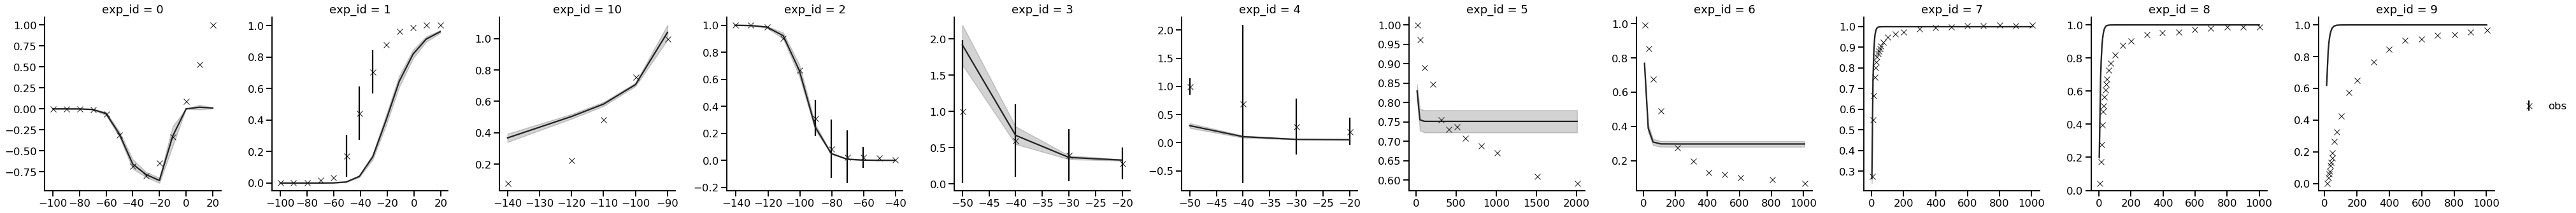

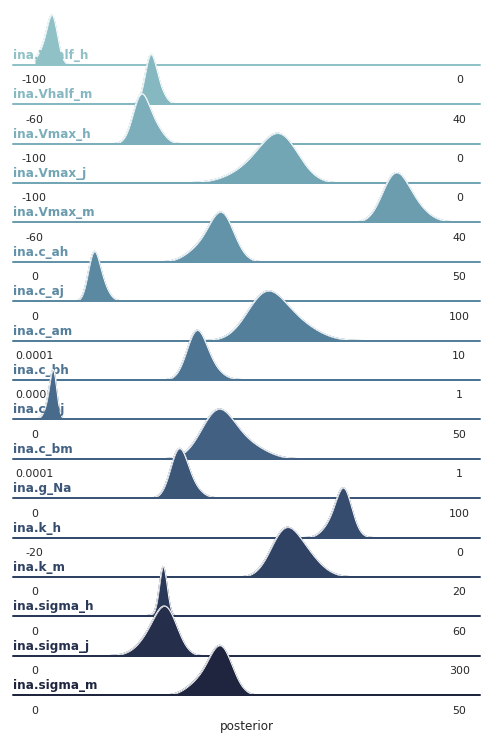

In [10]:
history = History(db_path)
history.all_runs()
history.id = 1  
df, w = history.get_distribution(m=0)

# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')
plotting_obs = observations.copy()

# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': plotting_obs.x, 'y': list(results.values()),
                           'exp_id': plotting_obs.exp_id})
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

sns.set_context('talk')


grid1 = plot_sim_results(samples, obs=plotting_obs)
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [15]:
grid1.savefig('../results/ina-generic/generic/ina_generic_posterior_sakakibara_exp_pop_1000.pdf')
grid2.savefig('../results/ina-generic/generic/ina_generic_experiments_sakakibara_exp_pop_1000.pdf')